In [1]:
import sys

sys.path = [p for p in sys.path if 'vast-1.4.2' not in p]
sys.path.insert(0, '/global/u2/z/ziqi/.local/lib/python3.9/site-packages/vast-1.6.1-py3.9-linux-x86_64.egg')

import vast
print("VAST imported successfully.")
print("Python executable:", sys.executable)
print("Python version:", sys.version)
print("VAST version:", vast.__version__)


VAST imported successfully.
Python executable: /global/homes/z/ziqi/python3.9/bin/python3.9
Python version: 3.9.9 (main, Nov 15 2024, 02:35:40) 
[GCC 12.3.0]
VAST version: 1.6.1


In [2]:
import os
import numpy as np

from astropy.table import QTable, Table
import fitsio
import pickle

from vast.catalog import void_catalog as vc
from vast.catalog.void_catalog import VoidFinderCatalogStacked

from vast.vsquared import zobov

from scipy.special import logsumexp, betaln, gammaln
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy import conf
from astropy.table import Table
from astropy.coordinates import Distance
from astropy.cosmology import Planck18, LambdaCDM


In [3]:
from vast.catalog.void_catalog import VoidFinderCatalog, V2Catalog

In [4]:
from astropy.io import fits
from astropy.table import Table

t = Table.read("BGS_filtered_data.fits")
print(t.colnames)


['Z', 'DEC', 'RA', 'ABS_MAG_R', 'ABS_MAG_U', 'ABS_MAG_G', 'LOG_MSTAR', 'HALPHA', 'HBETA', 'SFR', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'Color_ur', 'Color_gr', 'Halpha_EW']


In [5]:
vsquared_catalog = V2Catalog('DESIVAST_NGC_V2_REVOLVER_Output.fits')
voidfinder_voids_path = 'DESIVAST_NGC_VoidFinder_Output.fits'

voidfinder_catalog = VoidFinderCatalog(voidfinder_voids_path)
voidfinder_catalog.add_galaxies("BGS_filtered_data.fits", ra_name='RA',
    dec_name='DEC',
    redshift_name='Z')


vsquared_catalog.add_galaxies(
    "BGS_filtered_data.fits",
    ra_name='RA',
    dec_name='DEC',
    redshift_name='Z'
)


In [6]:
vsquared_catalog.galaxies['rabsmag'] = -30
vsquared_catalog.info['MAGLIM'] = 9999 

vsquared_catalog.mask = voidfinder_catalog.mask
vsquared_catalog.mask_info = voidfinder_catalog.mask_info
vsquared_catalog.info['MSKRES'] = voidfinder_catalog.info['MSKRES']

vflags, _ = vsquared_catalog.galaxy_membership(return_selector=True)

In [7]:
import numpy as np
from astropy.table import Table
from vast.catalog.void_catalog import V2Catalog, VoidFinderCatalog
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

# === Cosmology for comoving distance ===
cosmo = FlatLambdaCDM(H0=100, Om0=0.26)  # H0 in (km/s)/Mpc

# === Load data ===
galaxy_data = Table.read("BGS_filtered_data.fits")
vsquared_catalog = V2Catalog("DESIVAST_NGC_V2_REVOLVER_Output.fits")
voidfinder_catalog = VoidFinderCatalog("DESIVAST_NGC_VoidFinder_Output.fits")

# === Share mask ===
vsquared_catalog.mask = voidfinder_catalog.mask
vsquared_catalog.mask_info = voidfinder_catalog.mask_info
vsquared_catalog.info['MSKRES'] = voidfinder_catalog.info['MSKRES']

# === Extract coordinates ===
ra = np.array(galaxy_data['RA'])  # degrees
dec = np.array(galaxy_data['DEC'])  # degrees
z = np.array(galaxy_data['Z'])

# === Convert to comoving distance in Mpc/h ===
comoving_dist = cosmo.comoving_distance(z).value * vsquared_catalog.info['HP']  # HP = h

# === Convert to Cartesian coordinates ===
DtoR = np.pi / 180.0
x = comoving_dist * np.cos(dec * DtoR) * np.cos(ra * DtoR)
y = comoving_dist * np.cos(dec * DtoR) * np.sin(ra * DtoR)
z = comoving_dist * np.sin(dec * DtoR)

print("Coordinates converted.")

# === Check void membership by (x, y, z) ===
vflags = vsquared_catalog.check_object_in_void(x_pos=x, y_pos=y, z_pos=z)


galaxy_data['vflag_V2_xyz'] = vflags
galaxy_data.write("BGS_with_xyz_void_classification.fits", overwrite=True)


Coordinates converted.


In [8]:
unique, counts = np.unique(vflags, return_counts=True)
for v, c in zip(unique, counts):
    print(f"vflag={v}: {c} galaxies")


vflag=0: 69378 galaxies
vflag=1: 812160 galaxies
vflag=2: 310491 galaxies
vflag=9: 2186868 galaxies


# Slice Plot

In [9]:
from vast.catalog.void_slice_plots import VoidMapV2
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np

galaxy_data = Table.read("BGS_with_xyz_void_classification.fits")

#rename
galaxy_data['ra'] = galaxy_data['RA']
galaxy_data['dec'] = galaxy_data['DEC']
galaxy_data['redshift'] = galaxy_data['Z']
galaxy_data['rabsmag'] = galaxy_data['ABS_MAG_R']  

from vast.catalog.void_slice_plots import VoidMapV2
vsquared_slice_plot = VoidMapV2(
    vsquared_catalog.triangle,
    vsquared_catalog.galzone,
    vsquared_catalog.zonevoid,
    vsquared_catalog.voids,
    galaxy_data
)

vsquared_slice_plot.rmag = np.array(galaxy_data['rabsmag'], dtype=np.float32)



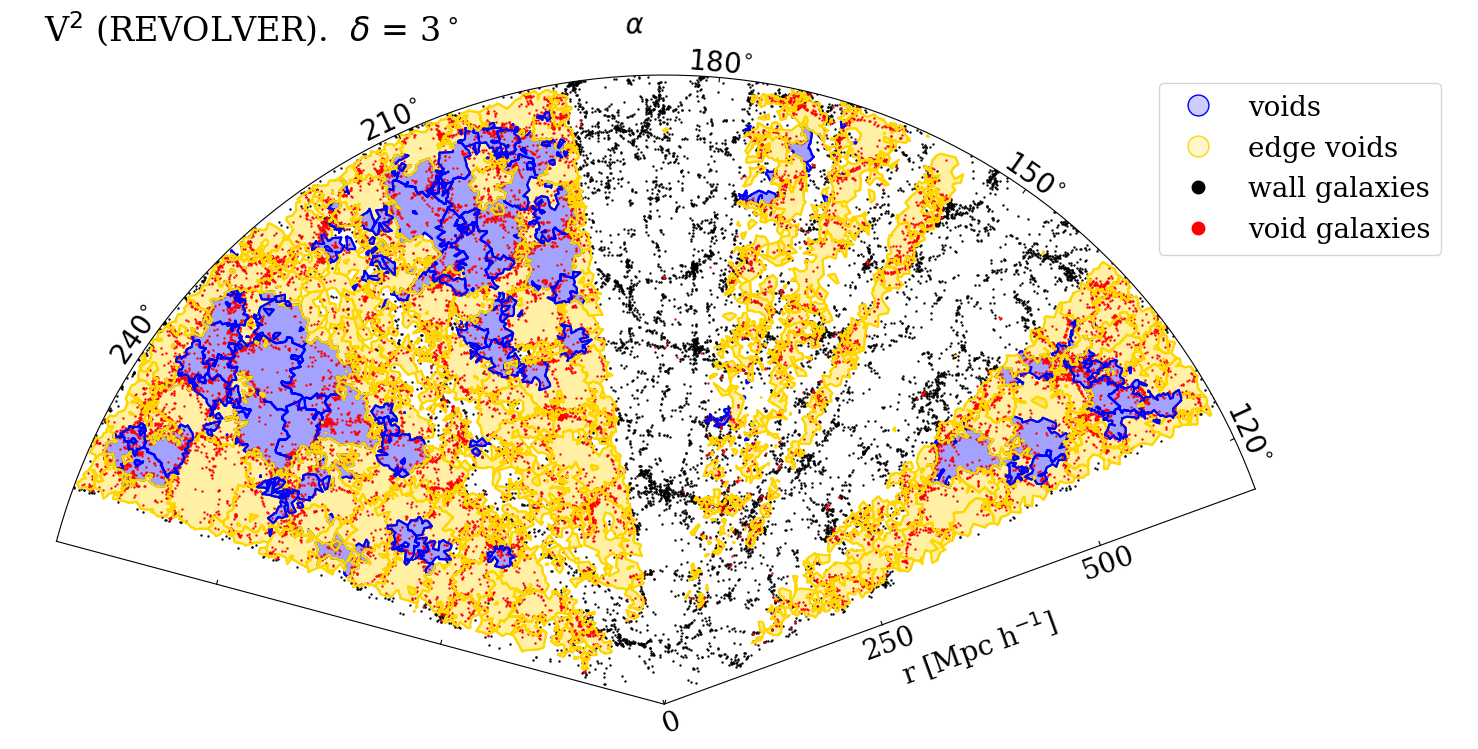

In [10]:
plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'axes.titley': 1.03})
graph = vsquared_slice_plot.plot_survey(3,5,
    115, 260, 0, 0.24,"V$^2$ (REVOLVER). ", graph = None, zlimits = True, rot = 265, 
    colors = ['gold','blue'],include_gals=True,alpha=0.2, border_alpha = 1, mag_limit=-20, 
    horiz_legend_offset=0.9, galaxy_point_size=.5, plot_sdss=False)
plt.show()

In [11]:
graph[0].figure.savefig("BGSbright_v2_slice_plot.png", format="png", bbox_inches="tight", dpi=150)

# Galaxy Property Plots

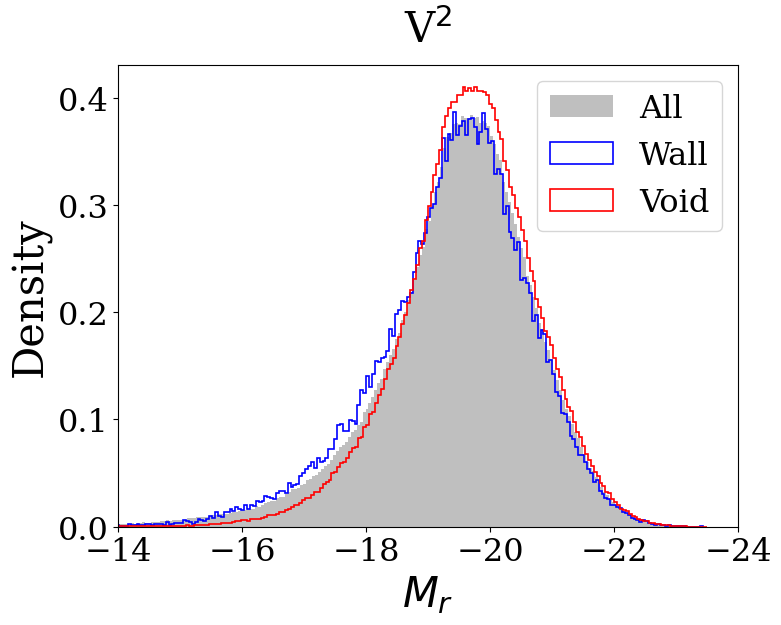

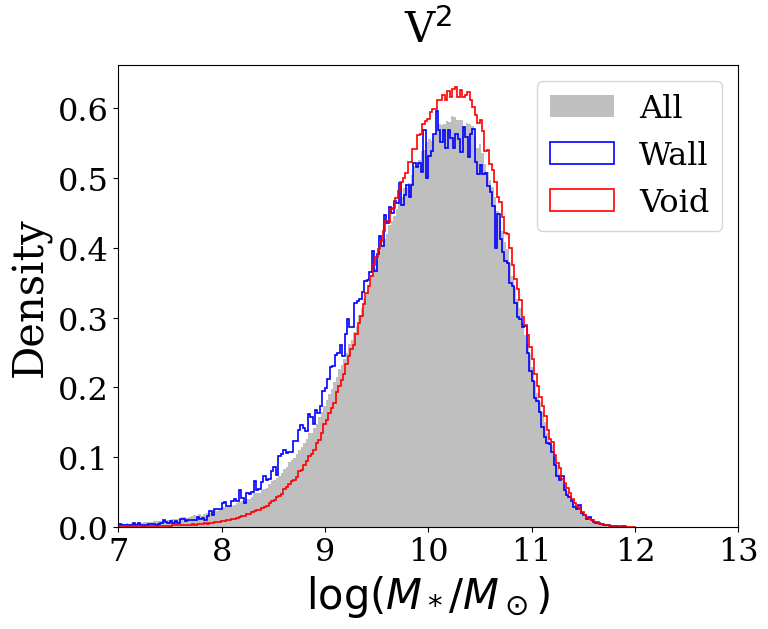

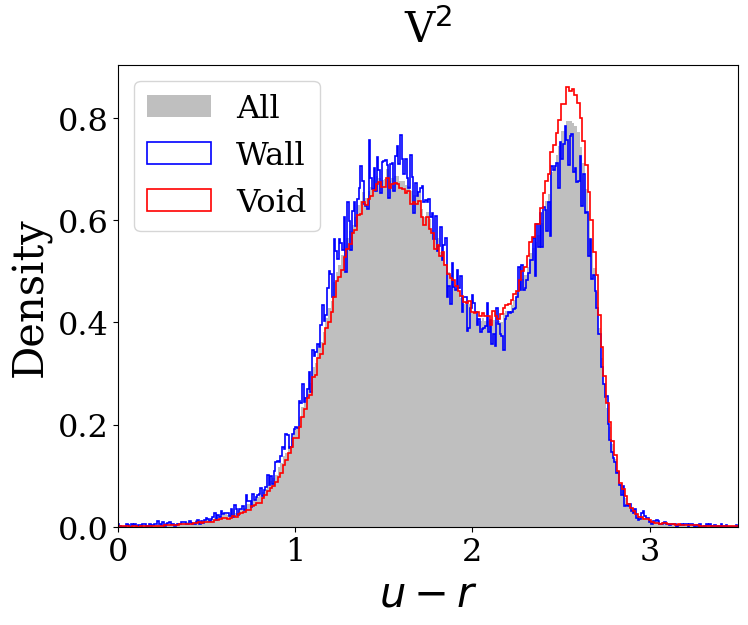

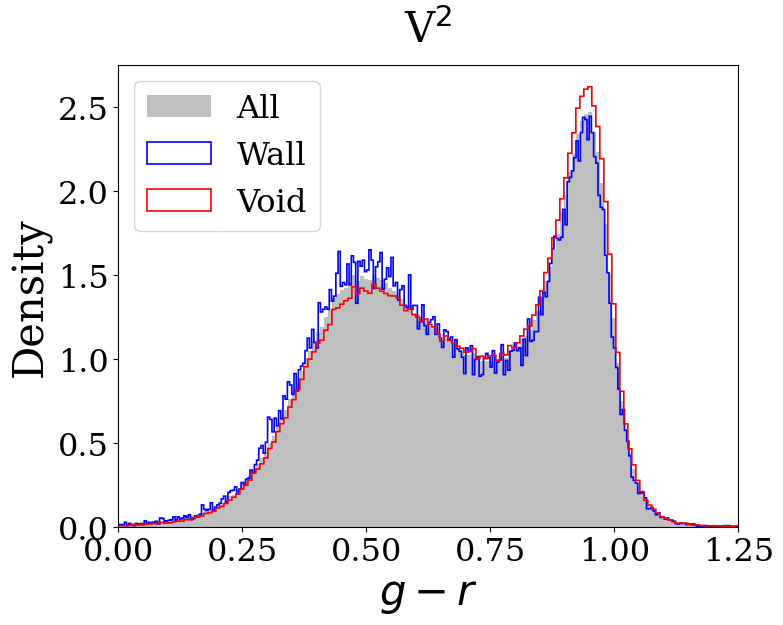

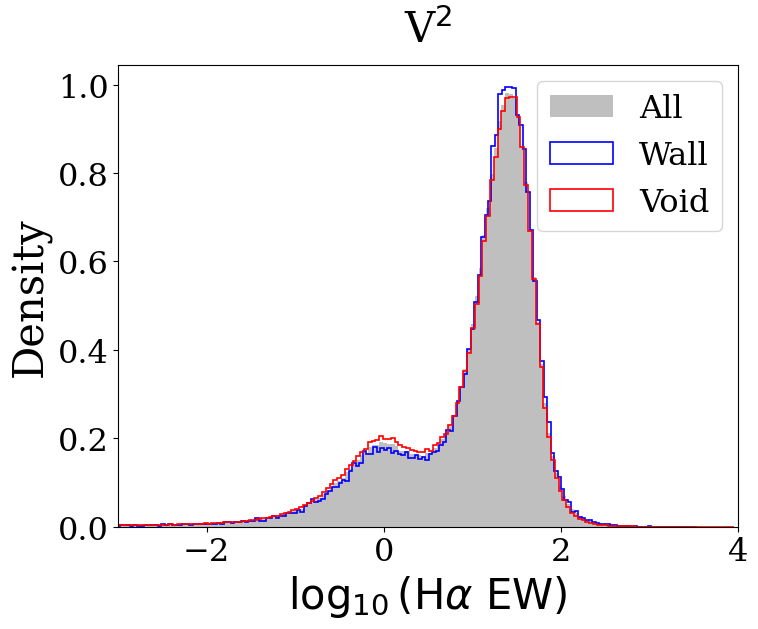

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

galaxies = Table.read("BGS_with_xyz_void_classification.fits")

wall_abs_mag_V2 = galaxies['ABS_MAG_R'][galaxies['vflag_V2_xyz'] == 0]
wall_log_mstar_V2 = galaxies['LOG_MSTAR'][galaxies['vflag_V2_xyz'] == 0]
wall_color_ur_V2 = galaxies['Color_ur'][galaxies['vflag_V2_xyz'] == 0]
wall_color_gr_V2 = galaxies['Color_gr'][galaxies['vflag_V2_xyz'] == 0]
wall_HalphaEW_V2 = galaxies['Halpha_EW'][galaxies['vflag_V2_xyz'] == 0]

void_abs_mag_V2 = galaxies['ABS_MAG_R'][galaxies['vflag_V2_xyz'] == 1]
void_log_mstar_V2 = galaxies['LOG_MSTAR'][galaxies['vflag_V2_xyz'] == 1]
void_color_ur_V2 = galaxies['Color_ur'][galaxies['vflag_V2_xyz'] == 1]
void_color_gr_V2 = galaxies['Color_gr'][galaxies['vflag_V2_xyz'] == 1]
void_HalphaEW_V2 = galaxies['Halpha_EW'][galaxies['vflag_V2_xyz'] == 1]

abs_mag_r_total = (
    galaxies['ABS_MAG_R'][galaxies['vflag_V2_xyz'] <= 2].tolist()
)
logmstar_total = (
    galaxies['LOG_MSTAR'][galaxies['vflag_V2_xyz'] <= 2].tolist()
)
ur_total = (
    galaxies['Color_ur'][galaxies['vflag_V2_xyz'] <= 2].tolist()
)
gr_total = (
    galaxies['Color_gr'][galaxies['vflag_V2_xyz'] <= 2].tolist()
)
HalphaEW = (
    galaxies['Halpha_EW'][galaxies['vflag_V2_xyz'] <= 2].tolist()
)


plt.rcParams.update({'font.size': 23})
size = 30

# 1. Absolute Magnitude (M_r)
plt.figure(figsize=(8, 6))
plt.hist(abs_mag_r_total, bins=500, density=True, alpha=0.5, color='gray', label='All')
plt.hist(wall_abs_mag_V2, bins=500, density=True, histtype='step', linewidth=1.2, color='blue', label='Wall')
plt.hist(void_abs_mag_V2, bins=500, density=True, histtype='step', linewidth=1.2, color='red', label='Void')
plt.xlabel(r"$M_r$", fontsize=size)
plt.ylabel("Density", fontsize=size)
plt.title("V$^2$", fontsize=size)
plt.legend()
plt.xlim(-14, -24)
plt.savefig("V2_Absolute_Magnitude.pdf", bbox_inches='tight')
plt.show()

# 2. Stellar Mass (Log M_star)
plt.figure(figsize=(8, 6))
plt.hist(logmstar_total, bins=500, density=True, alpha=0.5, color='gray', label='All')
plt.hist(wall_log_mstar_V2, bins=500, density=True, histtype='step', linewidth=1.2, color='blue', label='Wall')
plt.hist(void_log_mstar_V2, bins=500, density=True, histtype='step', linewidth=1.2, color='red', label='Void')
plt.xlabel(r'$\log({M_*}/{M_\odot})$', fontsize=size)
plt.ylabel("Density", fontsize=size)
plt.title("V$^2$", fontsize=size)
plt.legend()
plt.xlim(7, 13)
plt.savefig("V2_Stellar_Mass.pdf", bbox_inches='tight')
plt.show()

# 3. Color (u - r)
plt.figure(figsize=(8, 6))
plt.hist(ur_total, bins=500, density=True, alpha=0.5, color='gray', label='All')
plt.hist(wall_color_ur_V2, bins=500, density=True, histtype='step', linewidth=1.2, color='blue', label='Wall')
plt.hist(void_color_ur_V2, bins=500, density=True, histtype='step', linewidth=1.2, color='red', label='Void')
plt.xlim(0, 3.5)
plt.xlabel(r"$u-r$", fontsize=size)
plt.ylabel("Density", fontsize=size)
plt.title("V$^2$", fontsize=size)
plt.legend()
plt.savefig("V2_Color_ur.pdf", bbox_inches='tight')
plt.show()

# 4. Color (g - r)
plt.figure(figsize=(8, 6))
plt.hist(gr_total, bins=800, density=True, alpha=0.5, color='gray', label='All')
plt.hist(wall_color_gr_V2, bins=800, density=True, histtype='step', linewidth=1.2, color='blue', label='Wall')
plt.hist(void_color_gr_V2, bins=800, density=True, histtype='step', linewidth=1.2, color='red', label='Void')
plt.xlim(0, 1.25)
plt.xlabel(r"$g-r$", fontsize=size)
plt.ylabel("Density", fontsize=size)
plt.title("V$^2$", fontsize=size)
plt.legend()
plt.savefig("V2_Color_gr.pdf", bbox_inches='tight')
plt.show()

# 5. Hα EW (log scale)
HalphaEW_array = np.array(HalphaEW)
wall_HalphaEW_array = np.array(wall_HalphaEW_V2)
void_HalphaEW_array = np.array(void_HalphaEW_V2)

HalphaEW_positive = HalphaEW_array[HalphaEW_array > 0]
wall_HalphaEW_positive = wall_HalphaEW_array[wall_HalphaEW_array > 0]
void_HalphaEW_positive = void_HalphaEW_array[void_HalphaEW_array > 0]

HalphaEW_log = np.log10(HalphaEW_positive)
wall_HalphaEW_log = np.log10(wall_HalphaEW_positive)
void_HalphaEW_log = np.log10(void_HalphaEW_positive)

plt.figure(figsize=(8, 6))
plt.hist(HalphaEW_log, bins=500, density=True, alpha=0.5, color='gray', label='All')
plt.hist(wall_HalphaEW_log, bins=500, density=True, histtype='step', linewidth=1.2, color='blue', label='Wall')
plt.hist(void_HalphaEW_log, bins=500, density=True, histtype='step', linewidth=1.2, color='red', label='Void')
plt.xlabel(r"$\log_{10}(\mathrm{H}\alpha~\mathrm{EW})$", fontsize=size)
plt.ylabel("Density", fontsize=size)
plt.title("V$^2$", fontsize=size)
plt.legend()
plt.xlim(-3, 4)
plt.savefig("V2_HalphaEW.pdf", bbox_inches='tight')
plt.show()


# Calculate Bayes factor

In [13]:
def pt_d_sample_test(data1, data2, c = 1, max_depth=-1, qdist=norm.ppf, aj=lambda depth: depth**2, log_BF=False):
    if max_depth < 0:
        
       max_depth = 6   #set tree depth

    binary = np.concatenate((np.zeros(len(data1)), np.ones(len(data2))))
    continuous = np.concatenate((data1, data2))
    data = np.column_stack([scale(continuous), binary])   #with two columns
    X = data[:, 0]  # assign the first column to X
    discrete_values = np.unique(binary)    #[0,1]

    p_H0 = pt_marginal_likelihood(X, low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)

    p_H1 = max([pt_marginal_likelihood(data[data[:, 1] == i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj) +
                pt_marginal_likelihood(data[data[:, 1] != i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)
                for i in discrete_values])

    logbf = p_H0 - p_H1

    if log_BF:
        return logbf
    else:
        bf = np.exp(logbf)
        return bf

def pt_marginal_likelihood(data, low, up, c, depth, max_depth, qdist, aj):
    if depth == max_depth:
        return 0

    if isinstance(low, (int, float)):  # if low is an integer
        n_j = [
            np.sum((qdist(low) < data) & (data <= qdist((low + up) / 2))),
            np.sum((qdist((low + up) / 2) < data) & (data <= qdist(up)))
        ]   #counts the number of data in each interval


    if np.sum(n_j) == 0:
        return 0

    a_j = c * aj(depth)    #alpha

    if len(n_j) == 2:
        logl = betaln(n_j[0] + a_j, n_j[1] + a_j) - betaln(a_j, a_j)  #natural log of beta function
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj)
        ]  # likelihood of subpartitions


    return logl + np.sum(likelihoods)

def scale(data):
    return (data - np.mean(data)) / np.std(data)      #standardize

In [14]:
# Absolute Magnitude
bf_Mr = pt_d_sample_test(wall_abs_mag_V2, void_abs_mag_V2, log_BF=True)

# Stellar Mass
bf_mass = pt_d_sample_test(wall_log_mstar_V2, void_log_mstar_V2, log_BF=True)

# u-r Color
bf_ur = pt_d_sample_test(wall_color_ur_V2, void_color_ur_V2, log_BF=True)

# g-r Color
bf_gr = pt_d_sample_test(wall_color_gr_V2, void_color_gr_V2, log_BF=True)

# log10(Halpha EW)
bf_Ha = pt_d_sample_test(wall_HalphaEW_V2, void_HalphaEW_V2, log_BF=True)


In [15]:
bf_results = {
    "Absolute Magnitude": bf_Mr,
    "Stellar Mass": bf_mass,
    "Color (u-r)": bf_ur,
    "Color (g-r)": bf_gr,
    "log10(Hα EW)": bf_Ha
}

bf_results

{'Absolute Magnitude': -1600.3789182235487,
 'Stellar Mass': -1404.317426062189,
 'Color (u-r)': -223.95001863408834,
 'Color (g-r)': -190.24709590524435,
 'log10(Hα EW)': -75.89019296178594}